# Save GOES-16 IR channel subregion as NetCDF file
This jupyter notebook shows how to save a subregion of channel 13 (GOES-16) to NetCDF file using the GOES and pyresample packages. This methodology can be used with other ABI channels and ABI-derived products of GOES-16 and GOES-17. This tutorial consists of the following sections:

1- Get data from netcdf <br>
2- Resample data <br>
3- Save data as netcdf file <br>
4- Check the netcdf file <br>

<a id='get'></a>
## 1- Get data from netcdf

Import the GOES package.

In [1]:
import GOES

Set path and name of file that will be read.

In [2]:
path = '/home/joao/Downloads/GOES-16/ABI/'
file = 'OR_ABI-L2-CMIPF-M6C13_G16_s20200782000176_e20200782009496_c20200782010003.nc'

Reads the file.

In [3]:
ds = GOES.open_dataset(path+file)

Set the map domain.

In [4]:
domain = [-85.0,-65.0,-19.0,1.0] #LonMin, LonMax, LatMin, LatMax

Gets image with the coordinates of center of their pixels.

In [5]:
CMI, LonCen, LatCen = ds.image('CMI', lonlat='center', domain=domain)

Gets information about data.

In [6]:
sat = ds.attribute('platform_ID')
band = ds.variable('band_id').data[0]
wl = ds.variable('band_wavelength').data[0]
standard_name = CMI.standard_name
long_name = CMI.long_name
units = CMI.units
time_bounds = CMI.time_bounds

<a id='resample'></a>
## 2- Resample data
Since the netcdf data has satellite projection, it is necessary to reproject it to equirectangular projection to can save it as a geotiff. The follow steps teach how to do that.

Creates a grid map with cylindrical equidistant projection and 2 km of spatial resolution.

In [7]:
LonCenCyl, LatCenCyl = GOES.create_gridmap(domain, PixResol=2.0)

Calculates the parameters for reprojection. For this we need install the **pyproj** and **pyresample** packages. Do it writing ***pip install pyproj*** and ***pip install pyresample***.

In [8]:
import pyproj as pyproj
Prj = pyproj.Proj('+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km')
AreaID = 'cyl'
AreaName = 'cyl'
ProjID = 'cyl'
Proj4Args = '+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km'

ny, nx = LonCenCyl.data.shape
SW = Prj(LonCenCyl.data.min(), LatCenCyl.data.min())
NE = Prj(LonCenCyl.data.max(), LatCenCyl.data.max())
area_extent = [SW[0], SW[1], NE[0], NE[1]]

from pyresample import utils
AreaDef = utils.get_area_def(AreaID, AreaName, ProjID, Proj4Args, nx, ny, area_extent)

Reprojects image.

In [9]:
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest
import numpy as np

SwathDef = SwathDefinition(lons=LonCen.data, lats=LatCen.data)
CMICyl = resample_nearest(SwathDef, CMI.data, AreaDef, radius_of_influence=6000,
                          fill_value=np.nan, epsilon=3, reduce_data=True)

Deletes unnecessary data.

In [10]:
del CMI, LonCen, LatCen, SwathDef

<a id='save'></a>
## 3- Save data as netcdf file

To save the data as NetCDF we going to creates a functions called **save_as_netcdf**. For this we need NetCDF4 package, which is installed when GOES package is installed.

In [11]:
from netCDF4 import Dataset, date2num

def save_as_nc(Field, Dict, LonsCen, LatsCen, DateTimeField, OutputFile):

   # creates netcdf file
   dataset = Dataset(OutputFile, 'w', format='NETCDF4')

   # Dimensions - I recommend keep the same name for the dimensions
   dataset.createDimension('time', None)
   dataset.createDimension('level', None)
   dataset.createDimension('latitude', LatsCen.shape[0])
   dataset.createDimension('longitude', LonsCen.shape[0])

   # Variables
   file_time = dataset.createVariable('time', np.float64, ('time',))
   file_level = dataset.createVariable('level', np.float32, ('level',))
   file_lats = dataset.createVariable('latitude', LatsCen.dtype.type, ('latitude',))
   file_lons = dataset.createVariable('longitude', LonsCen.dtype.type, ('longitude',))
   file_field = dataset.createVariable(Dict['name'], Field.dtype.type, ('latitude','longitude'), zlib=True)

   # Sets variable attributes
   file_time.standard_name = 'time'
   file_time.long_name = 'time'
   file_time.units = 'hours since 2000-1-1 00:00:00'
   file_time.calendar = 'standard'
   file_time.axis = 'T'

   file_level.standard_name = 'level'
   file_level.long_name = 'level'
   file_level.units = 'millibars'
   file_level.positive = 'down'
   file_level.axis = 'Z'

   file_lats.standard_name = 'latitude'
   file_lats.long_name = 'latitude'
   file_lats.units = 'degrees_north'
   file_lats.axis = 'Y'

   file_lons.standard_name = 'longitude'
   file_lons.long_name = 'longitude'
   file_lons.units = 'degrees_east'
   file_lons.axis = 'X'

   file_field.standard_name = Dict['standard_name']
   file_field.long_name = Dict['long_name']
   file_field.units = Dict['units']
   file_field.axis = Dict['axis']

   # Writing variables
   file_time[:] = date2num(DateTimeField, units = file_time.units, calendar = file_time.calendar)
   file_level[:] = 1000.0
   file_lats[:] = LatsCen
   file_lons[:] = LonsCen
   file_field[:,:] = Field

   # Sets global attributes
   dataset.description = 'GOES-16 Satellite'
   dataset.source = 'NOAA-NASA'
   dataset.author = 'Joao Huaman (https://github.com/joaohenry23)'
   dataset.close()

Sets information of field.

In [12]:
dict = {'name':'CMI',
        'standard_name':standard_name,
        'long_name':long_name,
        'units':units,
        'axis':'YX'}

LonCenCyl1D = LonCenCyl.data[0,:] # Longitude of pixel center in 1D
LatCenCyl1D = LatCenCyl.data[:,0] # Latitude of pixel center in 1D
sst = time_bounds.data[0] # scan start time

Saves data as netcdf in **/home/joao/Downloads/** with the name **data.nc**.

In [13]:
save_as_nc(CMICyl, dict, LonCenCyl1D, LatCenCyl1D, sst, '/home/joao/Downloads/data.nc')

<a id='check'></a>
## 4- Check the netcdf file
Reads the netcdf file.

In [14]:
from netCDF4 import Dataset

ds = Dataset('/home/joao/Downloads/data.nc')
bnd = ds.variables['CMI'][:]
LonsCen = ds.variables['longitude'][:]
LatsCen = ds.variables['latitude'][:]

Calculates latitude and longitude of pixels corners.

In [15]:
xres = LonsCen[1]-LonsCen[0]
yres = LatsCen[1]-LatsCen[0]

LonsCor = np.concatenate((LonsCen-xres/2.0,[LonsCen[-1]+xres/2.0]),axis=0)
LatsCor = np.concatenate((LatsCen-yres/2.0,[LatsCen[-1]+yres/2.0]),axis=0)

LonsCor, LatsCor = np.meshgrid(LonsCor, LatsCor)

Creates the plot.

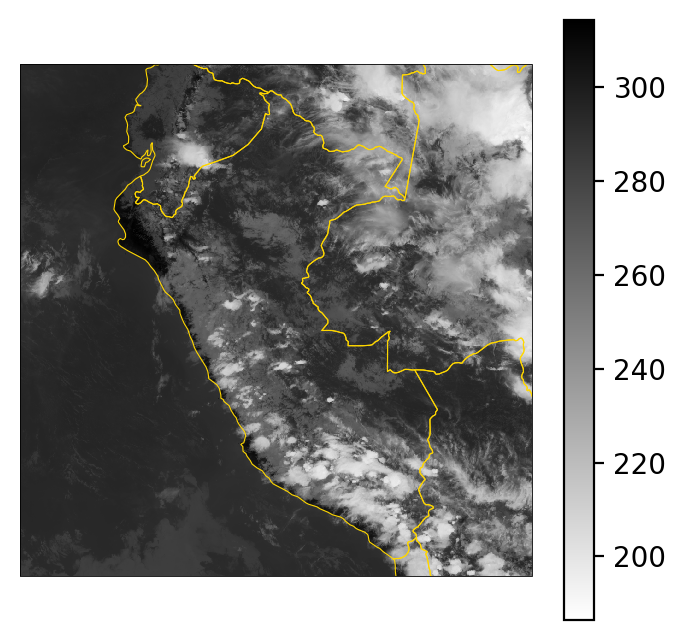

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# calculates the central longitude of the plot
LonCenPlot = LonsCor[0,:].mean() + 360.0

# calculates the extent of the plot
ExtentPlot = [LonsCor[0,0]+360.0, LonsCor[0,-1]+360.0, LatsCor[-1,0], LatsCor[0,0]]

# creates the figure
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(LonCenPlot))
#ax.outline_patch.set_linewidth(0.3)

# add the geographic boundaries
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='gold', linewidth=0.4)

# plot the data
img = ax.pcolormesh(LonsCor, LatsCor, bnd, cmap='gray_r', transform=ccrs.PlateCarree())

# add the colorbar
cb = plt.colorbar(img)

# set the map limits
ax.set_extent(ExtentPlot, crs=ccrs.PlateCarree())

plt.show()